<a href="https://colab.research.google.com/github/Mehul-Agrawal410/SOS_2023/blob/main/ISR_with_Pixel_Shuffle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
!wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
!tar xvf BSR_bsds500.tgz

--2023-07-18 19:44:56--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8000::1, 2620:12a:8001::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2023-07-18 19:44:56--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2023-07-18 19:44:56--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

In [4]:
train_path = './BSR/BSDS500/data/images/train/'
val_path = './BSR/BSDS500/data/images/val/'
test_path = './BSR/BSDS500/data/images/test/'

In [5]:
orig_size = (300, 300)
down_factor = 3

res_dense_blocks = 3
batch_size = 8
epochs = 100

In [6]:
def process_input(image_path, downFactor = down_factor):

	resizeShape = orig_size[0] // downFactor

	origImage = tf.io.read_file(image_path)
	origImage = tf.image.decode_jpeg(origImage, 3)
	origImage = tf.image.convert_image_dtype(origImage, tf.float32)
	origImage = tf.image.resize(origImage, orig_size, method="area")

	origImageYUV = tf.image.rgb_to_yuv(origImage)
	(target, _, _) = tf.split(origImageYUV, 3, axis=-1)

	downImage = tf.image.resize(target, [resizeShape, resizeShape], method="area")

	target = tf.clip_by_value(target, 0.0, 1.0)
	downImage = tf.clip_by_value(downImage, 0.0, 1.0)

	return (downImage, target)

In [7]:
def res_dense_block(inputs, numLayers):

  channels = inputs.get_shape()[-1]
  storedOutputs = [inputs]

  for _ in range(numLayers):
    localConcat = tf.concat(storedOutputs, axis=-1)
    out = Conv2D(channels, 3, padding = "same", activation="relu", kernel_initializer="Orthogonal")(localConcat)
    storedOutputs.append(out)

  finalConcat = tf.concat(storedOutputs, axis=-1)
  finalOut = Conv2D(channels, 1, padding = "same", activation="relu", kernel_initializer="Orthogonal")(finalConcat)
  outputs = Add()([finalOut, inputs])

  return finalOut

In [8]:
def get_subpixel_net(downSampleBy = down_factor, channels = 1, rdbBlocks = res_dense_blocks):

  inputs = Input((None, None, 1))

  x = Conv2D(64, 5, padding = 'same', activation = 'relu', kernel_initializer='Orthogonal')(inputs)
  x = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer='Orthogonal')(inputs)

  x = res_dense_block(x, rdbBlocks)
  x = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer='Orthogonal')(inputs)
  x = res_dense_block(x, rdbBlocks)

  x = Conv2D(channels * (downSampleBy ** 2), 3, padding = 'same', activation = 'relu', kernel_initializer='Orthogonal')(x)
  outputs = tf.nn.depth_to_space(x, downSampleBy)

  model = Model(inputs, outputs)
  return model

In [9]:
def psnr(orig, pred):

	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)

	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)

	return tf.image.psnr(orig, pred, max_val=255)

In [10]:
auto = tf.data.AUTOTUNE

trainPaths = list(paths.list_images(train_path))
valPaths = list(paths.list_images(val_path))
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
valDS = tf.data.Dataset.from_tensor_slices(valPaths)

In [13]:
trainDS = trainDS.map(process_input, num_parallel_calls = auto).batch(batch_size).prefetch(auto)
valDS = valDS.map(process_input, num_parallel_calls=auto).batch(batch_size).prefetch(auto)

model = get_subpixel_net()
model.compile(optimizer="adam", loss="mse", metrics=psnr)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   320         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 tf.identity_3 (TFOpLambda)     (None, None, None,   0           ['conv2d_18[0][0]']              
                                32)                                                         

In [14]:
history = model.fit(trainDS, validation_data=valDS, epochs=epochs)

Epoch 1/100
25/25 [==============================] - 15s 68ms/step - loss: 0.0712 - psnr: 12.1594 - val_loss: 0.0369 - val_psnr: 14.3840
Epoch 2/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0337 - psnr: 14.9597 - val_loss: 0.0192 - val_psnr: 16.9105
Epoch 3/100
25/25 [==============================] - 3s 123ms/step - loss: 0.0078 - psnr: 20.3314 - val_loss: 0.0054 - val_psnr: 21.3285
Epoch 4/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0045 - psnr: 23.0293 - val_loss: 0.0039 - val_psnr: 22.5956
Epoch 5/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0032 - psnr: 24.3045 - val_loss: 0.0030 - val_psnr: 24.4773
Epoch 6/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0027 - psnr: 25.0749 - val_loss: 0.0028 - val_psnr: 22.8810
Epoch 7/100
25/25 [==============================] - 2s 91ms/step - loss: 0.0025 - psnr: 25.3087 - val_loss: 0.0025 - val_psnr: 25.2629
Epoch 8/100
25/25 [===========================

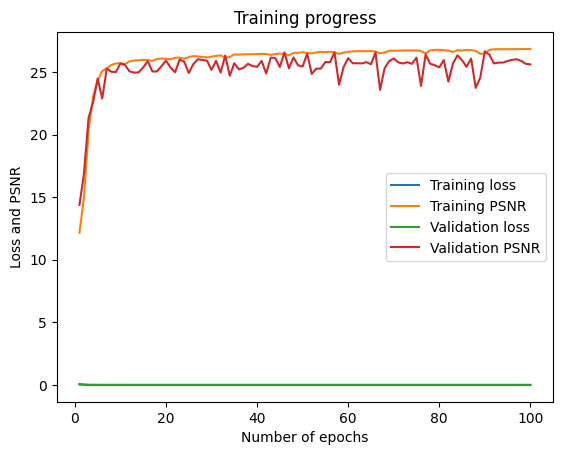

In [15]:
train_loss = history.history['loss']
train_psnr = history.history['psnr']
val_loss = history.history['val_loss']
val_psnr = history.history['val_psnr']

epoch_list = range(1, epochs + 1)

plt.plot(epoch_list, train_loss, label = "Training loss")
plt.plot(epoch_list, train_psnr, label = "Training PSNR")
plt.plot(epoch_list, val_loss, label = "Validation loss")
plt.plot(epoch_list, val_psnr, label = "Validation PSNR")

plt.xlabel('Number of epochs')
plt.ylabel('Loss and PSNR')
plt.title('Training progress')
plt.legend()

plt.show()

In [18]:
def load_image(path):
  origImage = load_img(path)
  lrImage = origImage.resize((origImage.size[0] // down_factor, origImage.size[1] // down_factor), Image.BICUBIC)
  return (origImage, lrImage)

In [20]:
def get_y_channel(image):

	ycbcr = image.convert("YCbCr")
	(y, cb, cr) = ycbcr.split()

	y = np.array(y)
	y = y.astype("float32") / 255.0

	return (y, cb, cr)

In [21]:
def clip_numpy(image):

	image = tf.cast(image * 255.0, tf.uint8)
	image = tf.clip_by_value(image, 0, 255).numpy()

	return image

In [22]:
def postprocess_image(y, cb, cr):

	y = clip_numpy(y).squeeze()
	y = y.reshape(y.shape[0], y.shape[1])
	y = Image.fromarray(y, mode="L")

	outputCB= cb.resize(y.size, Image.BICUBIC)
	outputCR= cr.resize(y.size, Image.BICUBIC)

	final = Image.merge("YCbCr", (y, outputCB, outputCR)).convert("RGB")
	return np.array(final)

In [23]:
testImages = list(paths.list_images(test_path))
currentTestImages = np.random.choice(testImages, 10)

1/1 [==============================] - 0s 297ms/step


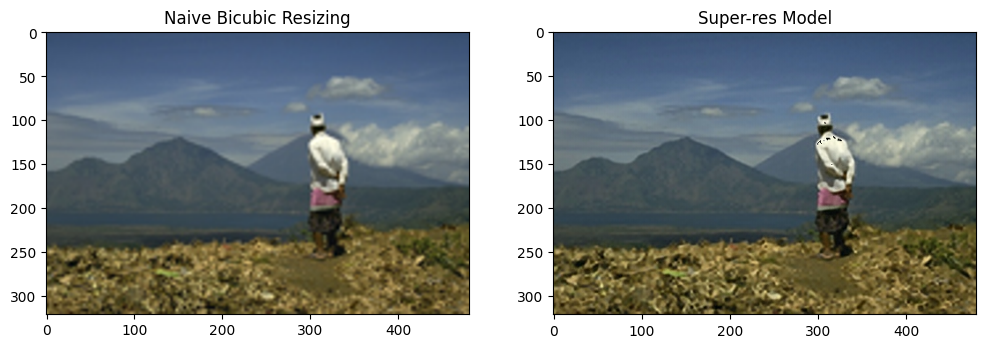

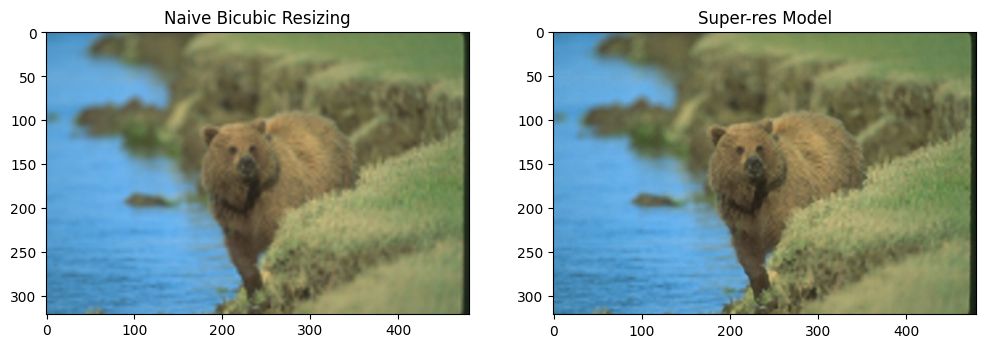

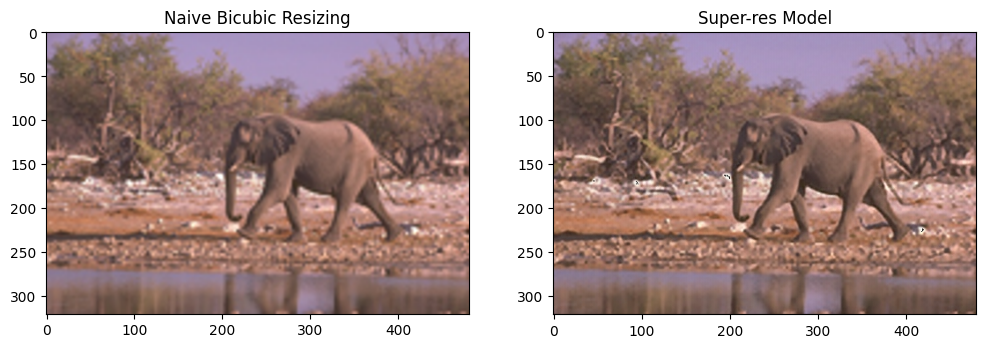

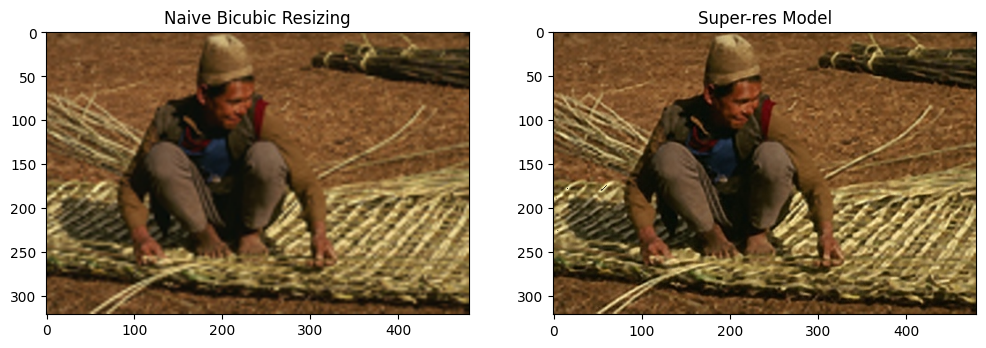

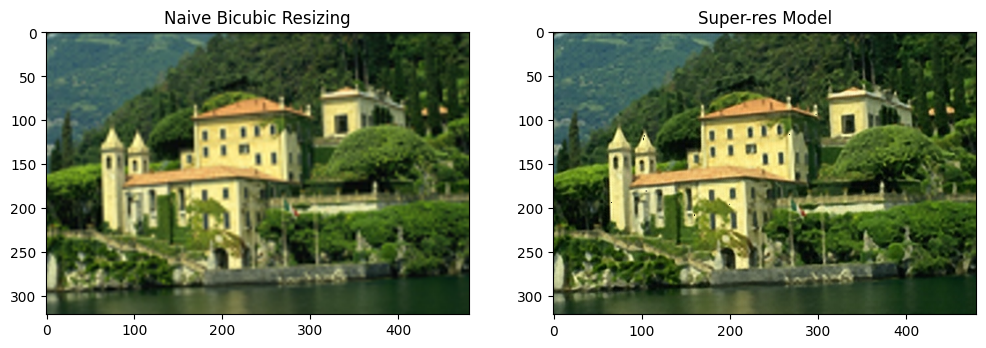

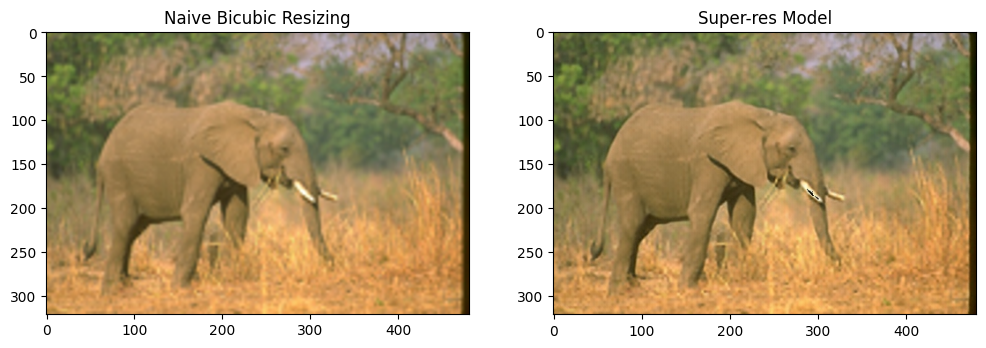

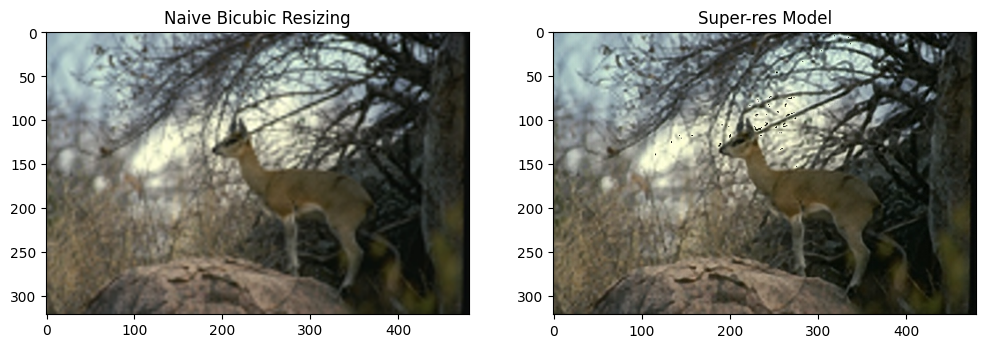

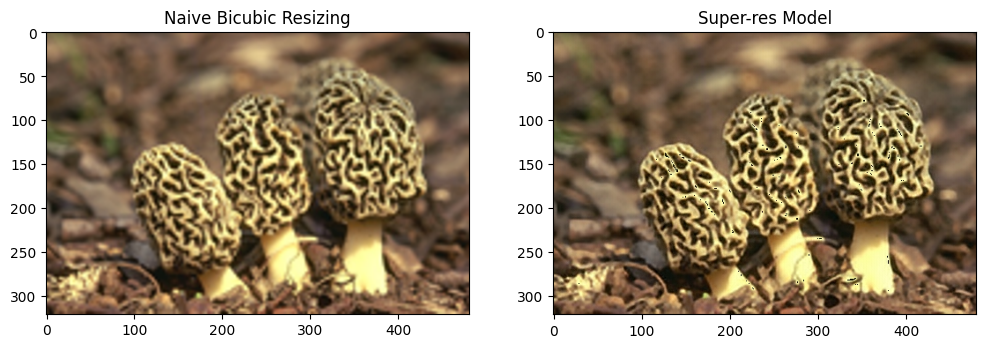

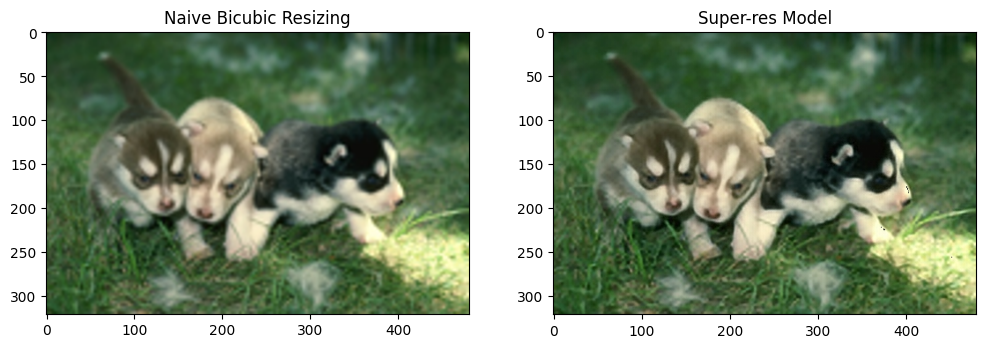

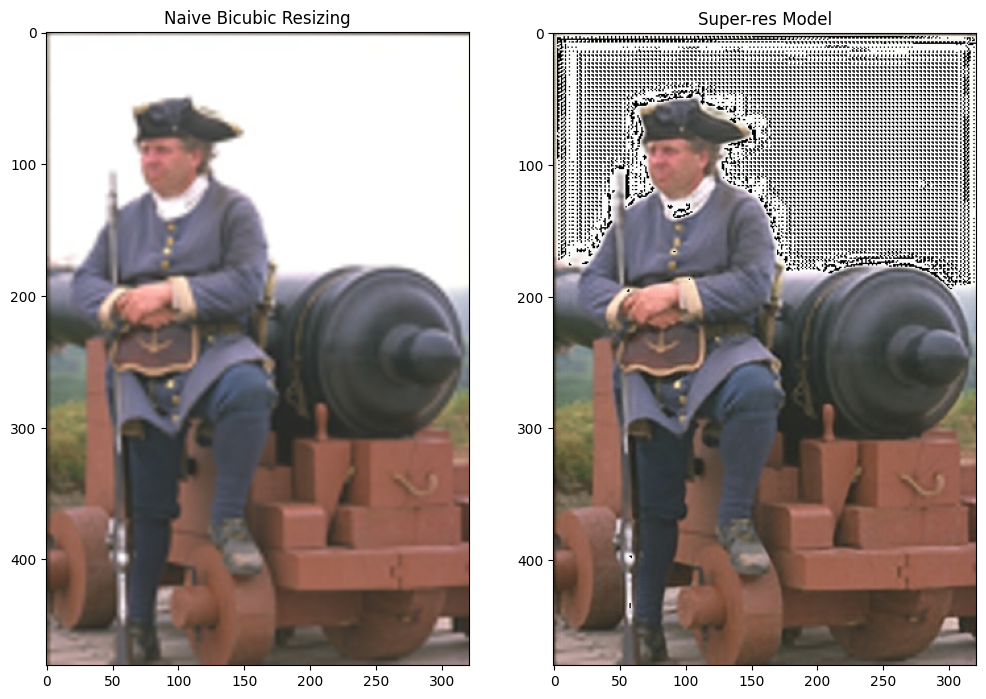

In [24]:
for (i, path) in enumerate(currentTestImages):

	(orig, downsampled) = load_image(path)

	(y, cb, cr) = get_y_channel(downsampled)
	upscaledY = model.predict(y[None, ...])[0]

	finalOutput = postprocess_image(upscaledY, cb, cr)
	naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)

	(fig, (ax1, ax2)) = plt.subplots(ncols=2, figsize=(12, 12))
	ax1.imshow(naiveResizing)
	ax2.imshow(finalOutput.astype("int"))
	ax1.set_title("Naive Bicubic Resizing")
	ax2.set_title("Super-res Model")